In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data
import symfem

In [2]:
t = np.linspace(0, 2*np.pi, 15, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

In [3]:
seg = np.array([[j, j+1] for j in range(points.shape[0]-1)] + [[points.shape[0] - 1, 0]])

In [4]:
cndt = triangulate({'vertices':points, 'segments':seg}, opts='Rpq3a0.5ne')

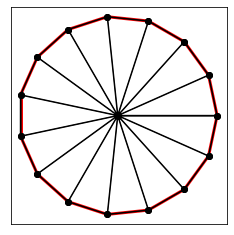

In [5]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4))
ax = plt.subplot(111, aspect='equal')
tplot(ax, **cndt)
# fig.savefig('../images/circle_mesh')
plt.show()

In [6]:
x, y, p1, p2, p3 = sympy.symbols("x, y, p1, p2, p3")
x1, x2, x3, y1, y2, y3 = sympy.symbols("x1:4 y1:4")

In [7]:
triangle_sym = np.array([
    [x1, y1],
    [x2, y2],
    [x3, y3],
    ])

BELL_BASIS = symfem.create_element("triangle", "Argyris", 5)

MAP = BELL_BASIS.reference.get_map_to(triangle_sym)
INV_MAP = BELL_BASIS.reference.get_inverse_map_to(triangle_sym)

In [ ]:
points = cndt['vertices']
triangles = cndt['triangles']
neighbours = cndt['neighbors']
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)

In [ ]:
tx = np.linspace(-1, 1, 1000)
ty = np.linspace(-1, 1, 1000)
xx, yy = np.meshgrid(tx, ty, indexing='xy')
points_ = np.stack((xx, yy)).transpose(1, 2, 0)

a = triangles_s[:, 0] - triangles_s[:, 1] 
b = triangles_s[:, 0] - triangles_s[:, 2] 
areas = np.abs(a[:, 0]*b[:, 1] - a[:, 1]*b[:, 0])

In [ ]:
a = (points_[...,] - triangles_s[:, 0, None, None])
b = (points_[...,] - triangles_s[:, 1, None, None])
c = (points_[...,] - triangles_s[:, 2, None, None])

area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])

indices = np.where(np.isclose((area1+area2+area3).transpose(1, 2, 0), areas[None, None, ...]))

# Basis functions

In [ ]:
q1 = p1**2*(3-2*p1)+2*p1*p2*p3
q1 = q1.subs(p3, 1-p1-p2)

q2 = p2**2*(3-2*p2)+2*p1*p2*p3
q2 = q2.subs(p3, 1-p1-p2)

q3 = p3**2*(3-2*p3)+2*p1*p2*p3
q3 = q3.subs(p3, 1-p1-p2)

In [ ]:
r1 = p1**2*(p1 - 1) - p1*p2*p3
r1 = r1.subs(p3, 1-p1-p2)

r2 = p2**2*p1 + 1/2*p1*p2*p3
r2 = r2.subs(p3, 1-p1-p2)

r3 = p3**2*p1 + 1/2*p1*p2*p3
r3 = r3.subs(p3, 1-p1-p2)

In [ ]:
s1 = p1**2*p2 + 1/2*p1*p2*p3
s1 = s1.subs(p3, 1-p1-p2)

s2 = p2**2*(p2 - 1) - p1*p2*p3
s2 = s2.subs(p3, 1-p1-p2)

s3 = p3**2*p2 + 1/2*p1*p2*p3
s3 = s3.subs(p3, 1-p1-p2)

In [ ]:
def transform_basis(arg):
    
    u = INV_MAP[0].subs({x1:arg[0, 0], x2:arg[1, 0], x3:arg[2, 0], 
                         y1:arg[0, 1], y2:arg[1, 1], y3:arg[2, 1],})

    v = INV_MAP[1].subs({x1:arg[0, 0], x2:arg[1, 0], x3:arg[2, 0], 
                         y1:arg[0, 1], y2:arg[1, 1], y3:arg[2, 1],})
    
    U = MAP[0].subs({x1:arg[0, 0], x2:arg[1, 0], x3:arg[2, 0], 
                         y1:arg[0, 1], y2:arg[1, 1], y3:arg[2, 1],})

    V = MAP[1].subs({x1:arg[0, 0], x2:arg[1, 0], x3:arg[2, 0], 
                         y1:arg[0, 1], y2:arg[1, 1], y3:arg[2, 1],})
    
    
    J = sympy.Matrix([u, v]).jacobian([x, y]).inv()
    
    R1 = J.row(0)[0]*r1 + J.row(0)[1]*s1
    R2 = J.row(0)[0]*r2 + J.row(0)[1]*s2
    R3 = J.row(0)[0]*r3 + J.row(0)[1]*s3
    
    S1 = J.row(1)[0]*r1 + J.row(1)[1]*s1
    S2 = J.row(1)[0]*r2 + J.row(1)[1]*s2
    S3 = J.row(1)[0]*r3 + J.row(1)[1]*s3
    
    
    return [q1.subs(p1, u).subs(p2, v), 
            q2.subs(p1, u).subs(p2, v), 
            q3.subs(p1, u).subs(p2, v),
            R1.subs(p1, u).subs(p2, v),
            R2.subs(p1, u).subs(p2, v),
            R3.subs(p1, u).subs(p2, v),
            S1.subs(p1, u).subs(p2, v),
            S2.subs(p1, u).subs(p2, v),
            S3.subs(p1, u).subs(p2, v)
           ]

In [ ]:
fn_values = np.zeros((points.shape[0], 3))
fn_values[-1] = 1

In [ ]:
tx = np.linspace(-1.5, 1.5, 1000)
ty = np.linspace(-1.5, 1.5, 1000)
mx, my = np.meshgrid(tx, ty, indexing="ij")
mz = np.zeros_like(mx)
points_ = np.stack((mx, my)).transpose(1, 2, 0)

for idx, (p_idx, t_points) in enumerate(zip(triangles, triangles_s)):
        
        
    this_triangle = t_points.copy()
    
    a = this_triangle[0] - this_triangle[1]
    b = this_triangle[0] - this_triangle[2]
    areas = np.abs(a[0]*b[1] - a[1]*b[0])        
    a = (points_[...,] - this_triangle[0, None, None])
    b = (points_[...,] - this_triangle[1, None, None])
    c = (points_[...,] - this_triangle[2, None, None])
    area1 = np.abs(a[..., 0] * b[..., 1] - a[..., 1] * b[..., 0])
    area2 = np.abs(a[..., 0] * c[..., 1] - a[..., 1] * c[..., 0])
    area3 = np.abs(b[..., 0] * c[..., 1] - b[..., 1] * c[..., 0])
    indices = np.where(np.isclose((area1+area2+area3), areas))
    
    cb = transform_basis(this_triangle)
    
    resulting_fn = \
                    fn_values[p_idx[1]][0]*cb[0]+ \
                    fn_values[p_idx[2]][0]*cb[1]+ \
                    fn_values[p_idx[0]][0]*cb[2]
    resulting_fn_x = \
                    fn_values[p_idx[1]][1]*cb[3]+ \
                    fn_values[p_idx[2]][1]*cb[4]+ \
                    fn_values[p_idx[0]][1]*cb[5]
    resulting_fn_y = \
                    fn_values[p_idx[1]][2]*cb[6]+ \
                    fn_values[p_idx[2]][2]*cb[7]+ \
                    fn_values[p_idx[0]][2]*cb[8]
    
    
    vals = sympy.lambdify((x, y), resulting_fn)(mx, my)
    
    if isinstance(vals, (int, float)):
        vals = np.ones_like(mz)*vals
        
    mz[indices] = vals[indices]

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(mx, my, mz, cmap="magma")
ax.set_box_aspect((np.ptp(mx), np.ptp(my), np.ptp(mz)))
plt.show()

In [ ]:
# fig.savefig("../images/hermit_cubic_fy.png", dpi=300)